<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Copy_of_epidemiology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Noise-free data


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import special_ortho_group

## 1.1


In [2]:
def simulate_sir_simple(lam, mu, I_0, T):
    """
    simulates the epidemy using the Euler forward scheme up to day T.
    lam = infection rate
    mu = recovery rate
    I_0 = initial percentage of infected people
    T = days to simulate
    """
    # Initialize variables
    S = 1.0 - I_0
    I = I_0
    R = 0.0

    # Lists to store observations and ODE variables
    X = np.zeros((T, 2))
    C = np.zeros((T, 3))

    for day in range(T):
        # Ensure variables are within bounds
        S = max(min(S, 1.0), 0.0)
        I = max(min(I, 1.0), 0.0)
        R = max(min(R, 1.0), 0.0)

        # Check for population total exceeding 1 due to numerical error
        if S + I + R > 1.0:
            excess = S + I + R - 1.0
            S -= excess * S / (S + I + R)
            I -= excess * I / (S + I + R)
            R -= excess * R / (S + I + R)

        # Calculate new values using Euler forward scheme
        new_infections = lam * S * I
        dS = -new_infections
        dI = new_infections - mu * I
        dR = mu * I

        S += dS
        I += dI
        R += dR

        # Append current values to the lists
        X[day] = [dS, dR]
        C[day] = [S, I, R]

    return X, C

## 1.2


In [3]:
def plot_sir_simulation(C, title='SIR Model Simulation'):
    """
    Plots the SIR simulation results.

    C: Array containing the S, I, R values at each timestep
    T: Total number of days in the simulation
    """
    days = range(len(C))

    # Extract S, I, R values
    S, I, R = C[:, 0], C[:, 1], C[:, 2]

    # Plotting
    plt.figure(figsize=(7, 4))
    plt.plot(days, S, label='Susceptible')
    plt.plot(days, I, label='Infected')
    plt.plot(days, R, label='Recovered')

    plt.xlabel('Days')
    plt.ylabel('Population Proportion')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    #plt.show()

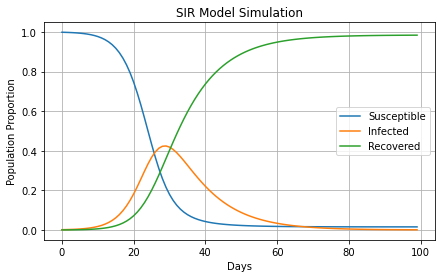

In [30]:
lambda_val = 0.4
mu_val = 0.1
initial_infected = 0.001
num_days = 100

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

After some trial and error we found values $\lambda$ = 0.25, $\mu$ = 0.1, and $I_0$ = 0.001 that exhibit interesting and diverse dynamics. Now we look at the ranges of each value where we still see interesting dynamics


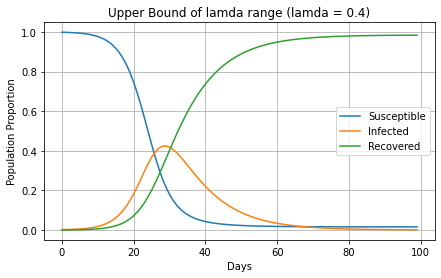

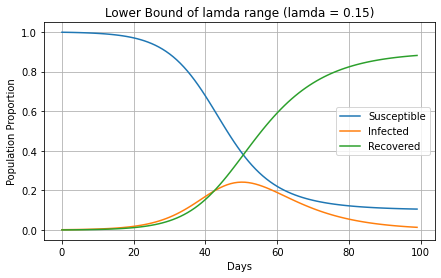

In [31]:
lambda_val_1 = 0.40
lambda_val_2 = 0.25

X_1, C_1 = simulate_sir_simple(
    lambda_val_1, mu_val, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(
    lambda_val_2, mu_val, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of lamda range (lamda = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of lamda range (lamda = 0.15)")

So lambda should be in the range between $\lambda = [0.25, 0.4]$. Lets do the same with $\mu$ and $I_0$


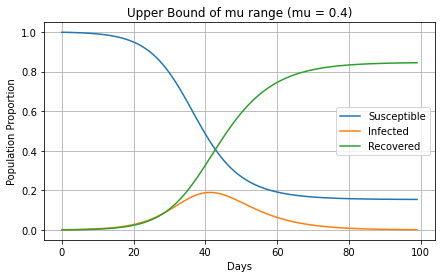

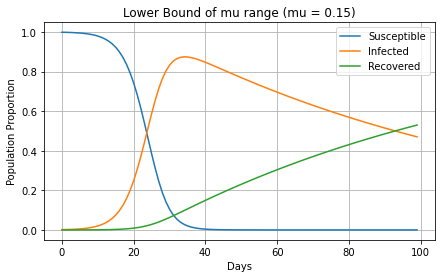

In [32]:
mu_val_1 = 0.15
mu_val_2 = 0.01
lambda_val = 0.325

X_1, C_1 = simulate_sir_simple(
    lambda_val, mu_val_1, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(
    lambda_val, mu_val_2, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of mu range (mu = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of mu range (mu = 0.15)")

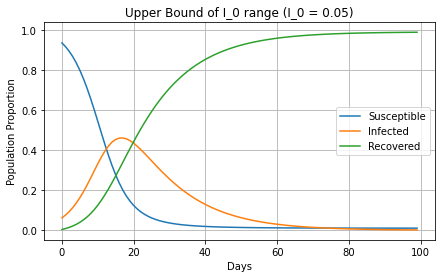

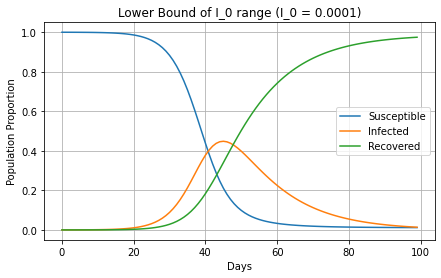

In [33]:
mu_val = 0.075
initial_infected_1 = 0.05
initial_infected_2 = 0.0001


X_1, C_1 = simulate_sir_simple(
    lambda_val, mu_val, initial_infected_1, num_days)
X_2, C_2 = simulate_sir_simple(
    lambda_val, mu_val, initial_infected_2, num_days)

plot_sir_simulation(C_1, title="Upper Bound of I_0 range (I_0 = 0.05)")
plot_sir_simulation(C_2, title="Lower Bound of I_0 range (I_0 = 0.0001)")

From our test we get suitable range of:  
$\lambda = [0.25, 0.4]$
$\mu = [0.01, 0.15]$
$I_0 = [0.0001, 0.05]$


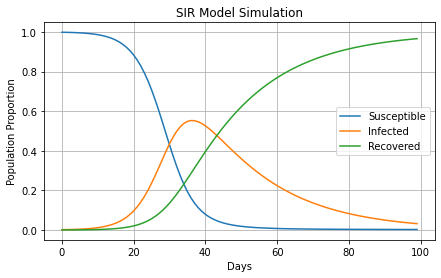

In [34]:
lambda_val = 0.3
mu_val = 0.05
initial_infected = 0.001
num_days = 100

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

## 1.3


First, we define a dataset for training:


In [4]:
class SIRDataset(Dataset):
    def __init__(self, size, T):
        self.size = size
        self.T = T
        self.data = []
        self.targets = []

        lam_prior = np.random.uniform(0.25, 0.4, size=size)
        mu_prior = np.random.uniform(0.01, 0.15, size=size)
        I_0_prior = np.random.uniform(0.0001, 0.05, size=size)

        for i in range(size):
            lam = lam_prior[i]
            mu = mu_prior[i]
            I_0 = I_0_prior[i]
            X, _ = simulate_sir_simple(lam, mu, I_0, T)
            self.data.append(X)
            self.targets.append([lam, mu, I_0])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

Next, we define a network architecture and train it on our datasets


In [5]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers, output_size=3):# output_size=3 (default) for no noise case
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, output_size))  # Output layer

        # Register the layer list as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x


def train_network(net, train_loader, validation_loader, optimizer, criterion, epochs=5):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        # Train:
        train_loss = 0
        net.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate:
        net.eval()
        validation_loss = 0
        with torch.no_grad():
            for data, targets in validation_loader:
                outputs = net(data)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        validation_loss = validation_loss/len(validation_loader)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(
            f"[{epoch}/{epochs}] train loss: {train_loss}, validation loss: {validation_loss}")

    return train_losses, validation_losses


def evaluate_network(net, test_loader, criterion):
    with torch.no_grad():
        test_loss = 0
        for data, targets in test_loader:
            outputs = net(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        test_loss = test_loss/len(test_loader)
    return test_loss


def plot_losses(validation_loss, train_loss=None, label="validation"):
    if train_loss is not None:
        plt.plot(train_loss, label="training")
    plt.plot(validation_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

In [6]:
train_dataset = SIRDataset(size=1000, T=100)
validation_dataset = SIRDataset(size=200, T=100)
test_dataset = SIRDataset(size=200, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
criterion = nn.MSELoss()

[0/10] train loss: 0.011315084164380096, validation loss: 0.004252938686736992
[1/10] train loss: 0.002115091097948607, validation loss: 0.0011186127168392496
[2/10] train loss: 0.0011001395869243424, validation loss: 0.0009979545221930103
[3/10] train loss: 0.0009871344300336204, validation loss: 0.0008719458544094648
[4/10] train loss: 0.0008816517311061034, validation loss: 0.0007544852726693664
[5/10] train loss: 0.0007804033411957789, validation loss: 0.0006772115302737802
[6/10] train loss: 0.0006774328721803613, validation loss: 0.0005568870983552188
[7/10] train loss: 0.0005963215871815919, validation loss: 0.0004911277002455401
[8/10] train loss: 0.0005414760216808645, validation loss: 0.00045425905097675113
[9/10] train loss: 0.0005100973330627312, validation loss: 0.00042988436429628303


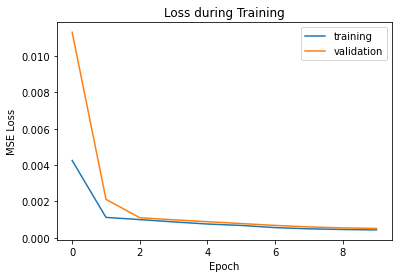

In [38]:
net = SIRNet(input_size=100*2, hidden_size=50, n_hidden_layers=0)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss, validation_loss = train_network(
    net, train_loader, validation_loader, optimizer, criterion, 10)
plot_losses(train_loss, validation_loss)
plt.title("Loss during Training")
plt.legend()
plt.show()

In [39]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [10, 50, 100]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size,
                     n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _, validation_loss = train_network(
            net, train_loader, validation_loader, optimizer, criterion, 10)

[0/10] train loss: 0.08257042081095278, validation loss: 0.06686762188162122
[1/10] train loss: 0.054468386457301676, validation loss: 0.04080137557217053
[2/10] train loss: 0.030817723600193858, validation loss: 0.020846599712967873
[3/10] train loss: 0.01397539721801877, validation loss: 0.007999914432210582
[4/10] train loss: 0.004821502472623251, validation loss: 0.002525380014308861
[5/10] train loss: 0.001692956373517518, validation loss: 0.0011698183370754123
[6/10] train loss: 0.0010967532034555916, validation loss: 0.0010010840238205024
[7/10] train loss: 0.0009815997582336422, validation loss: 0.0008962764238406505
[8/10] train loss: 0.0009234009248757502, validation loss: 0.0008676551265775093
[9/10] train loss: 0.0008603307123848936, validation loss: 0.0007908006248596523
[0/10] train loss: 0.03095886085066013, validation loss: 0.013502132945827075
[1/10] train loss: 0.006897531719005201, validation loss: 0.0027607092301228215
[2/10] train loss: 0.001973072114196839, valida

[0/20] train loss: 0.01744810916716233, validation loss: 0.003910073977229851
[1/20] train loss: 0.00158190195725183, validation loss: 0.001034368503107024
[2/20] train loss: 0.0009456504085392226, validation loss: 0.0008226199674287013
[3/20] train loss: 0.0007818719859642442, validation loss: 0.000645194052984672
[4/20] train loss: 0.0006680485621473053, validation loss: 0.0005227681207803211
[5/20] train loss: 0.0005654553442582255, validation loss: 0.0004982789604192865
[6/20] train loss: 0.0005180444850338972, validation loss: 0.00045734751620329916
[7/20] train loss: 0.0004915139943477698, validation loss: 0.00042122212887209443
[8/20] train loss: 0.00047646746770624304, validation loss: 0.00046866227889300456
[9/20] train loss: 0.0004765953244714183, validation loss: 0.0004018690337293914
[10/20] train loss: 0.00047131509472819744, validation loss: 0.00042040522592807453
[11/20] train loss: 0.00046560516148019815, validation loss: 0.00041885678989014456
[12/20] train loss: 0.000

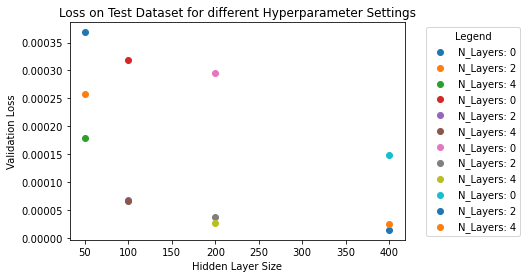

In [40]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [50, 100, 200, 400]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size,
                     n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _, _ = train_network(
            net, train_loader, validation_loader, optimizer, criterion, 20)
        test_loss = evaluate_network(net, test_loader, criterion)

        plt.scatter(hidden_size, test_loss, label=f'N_Layers: {n_layer}')


plt.xlabel('Hidden Layer Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')
# Move the legend outside the plot using bbox_to_anchor
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

plt.title('Loss on Test Dataset for different Hyperparameter Settings')
plt.show()

We see the larger the network the better the performance in our case and we get the best results for 4 layers and a hidden size of 400. We can also observe that having more layers in these tests have a stronger influence on the outcome than the hidden size. For now we stick with our found network parameter since they perform good enough for our case.

Lets now look into variable dataset sizes


[0/20] train loss: 0.006807945093896706, validation loss: 0.001733347657136619
[1/20] train loss: 0.0013861790976079646, validation loss: 0.001346846210903355
[2/20] train loss: 0.001309170271269977, validation loss: 0.0012294476785297906
[3/20] train loss: 0.001227433436724823, validation loss: 0.0011933517026981072
[4/20] train loss: 0.0012011087237624452, validation loss: 0.0012376652115822903
[5/20] train loss: 0.0011430915947130416, validation loss: 0.0009872695248174881
[6/20] train loss: 0.00103444518026663, validation loss: 0.0007989419100340456
[7/20] train loss: 0.0009451041260035709, validation loss: 0.0008334703992919198
[8/20] train loss: 0.0008646652022434864, validation loss: 0.0007269857451319695
[9/20] train loss: 0.0008150117573677562, validation loss: 0.0007106807980952519
[10/20] train loss: 0.0006654685566900298, validation loss: 0.0007096007216854819
[11/20] train loss: 0.0005034603636886459, validation loss: 0.0003576922879022147
[12/20] train loss: 0.00031179700

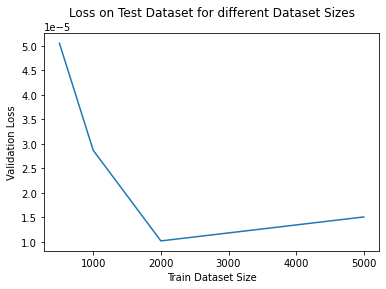

In [41]:
trainset_sizes = [500, 1000, 2000, 5000]
test_losses = []
for train_size in trainset_sizes:
    train_dataset = SIRDataset(size=train_size, T=100)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    net = SIRNet(input_size=100*2, hidden_size=400, n_hidden_layers=4)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    _, _ = train_network(
        net, train_loader, validation_loader, optimizer, criterion, 20)
    test_loss = evaluate_network(net, test_loader, criterion)
    test_losses.append(test_loss)


plt.plot(trainset_sizes, test_losses)

plt.xlabel('Train Dataset Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')

plt.title('Loss on Test Dataset for different Dataset Sizes')
plt.show()

We can't see any substantial improvements after a dataset size of 1000


## 1.4


In [14]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, feature_size, n_hidden_layers):
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, feature_size))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
def subnet_constructor(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    return model


def ortogonal_matrix(dim):
    Q = special_ortho_group.rvs(dim)
    return torch.Tensor(Q)


class ConditionalCouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1
        self.subnet = subnet_constructor(
            self.split1 + self.condition_size, self.hidden_size, 2*self.split2)

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]

        params = self.subnet(torch.cat([x1, cond], -1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)

        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1, x2], -1), ljd
        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1, x2], -1)


class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.condition_size = condition_size

        self.coupling_blocks = nn.ModuleList([ConditionalCouplingBlock(
            input_size, hidden_size, self.condition_size) for _ in range(n_blocks)])
        self.orthogonal_matrices = [ortogonal_matrix(
            input_size) for _ in range(n_blocks-1)]

    def forward(self, x, cond, rev=False):
        if rev:
            return self._inverse(x, cond)
        return self._forward(x, cond)

    def _forward(self, x, cond):
        ljd = torch.zeros((x.shape[0]))
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x, cond)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x, cond)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x, cond):
        for l in range(self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        samples = []
        if cond is None:
            for c in range(self.condition_size):
                z = torch.normal(mean=torch.zeros(
                    (num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
                samples.append(self._inverse(z, cond=c.repeat(num_samples, 1)))
        else:
            z = torch.normal(mean=torch.zeros(
                (num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
            samples.append(self._inverse(z, cond=cond.repeat(num_samples, 1)))
        return torch.cat(samples, 0)

In [9]:
# conditional real NVP class
class FusionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size_sir, feature_size, n_layers_sir, hidden_size_nvp, input_size_nvp, blocks):
        super(FusionNetwork, self).__init__()

        self.feature_size = feature_size

        self.summary_net = SIRNet(input_size=input_size,
                                  hidden_size=hidden_size_sir,
                                  n_hidden_layers=n_layers_sir,
                                  feature_size=feature_size)

        self.real_nvp = ConditionalRealNVP(input_size=input_size_nvp,
                                           hidden_size=hidden_size_nvp,
                                           n_blocks=blocks,
                                           condition_size=feature_size)

    def forward(self, x, y):
        condition = self.summary_net(x)
        x = self.real_nvp(y, condition)
        return x

    def sample_posterior(self, x, num_samples):
        condition = self.summary_net(x)
        return self.real_nvp.sample(num_samples=num_samples, cond=condition)

In [10]:
def training_per_epoch(model, train_loader, optimizer, batchsize):
    model.train()
    loss_sum = 0
    for input, ground_truth in train_loader:
        optimizer.zero_grad()
        z, ljd = model(input, ground_truth)
        loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum/len(train_loader)


def validation_per_epoch(model, validation_loader, batchsize):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for input, ground_truth in validation_loader:
            z, ljd = model(input, ground_truth)
            loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
            loss_sum += loss.item()
    return loss_sum/len(validation_loader)


def train_fusion(model, train_loader, validation_loader, batchsize=32, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = training_per_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer, batchsize=batchsize)
        validation_loss = validation_per_epoch(
            model=model, validation_loader=validation_loader, batchsize=batchsize)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss}")

Training both networks together:


In [46]:
params = {'input_size': 2*100,
          'hidden_size_sir': 200,
          'feature_size': 50,
          'n_layers_sir': 4,
          'hidden_size_nvp': 200,
          'input_size_nvp': 3,
          'blocks': 10}

train_dataset = SIRDataset(size=1000, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = FusionNetwork(**params)
train_fusion(model, train_loader, validation_loader, epochs=50)

Epoch [1/50], Train Loss: -6.0906, Validation Loss: -7.856409447533744
Epoch [2/50], Train Loss: -8.7062, Validation Loss: -8.119542803083148
Epoch [3/50], Train Loss: -8.7948, Validation Loss: -8.000842945916313
Epoch [4/50], Train Loss: -8.7014, Validation Loss: -8.120255640574864
Epoch [5/50], Train Loss: -8.2351, Validation Loss: -6.751836708613804
Epoch [6/50], Train Loss: -8.3410, Validation Loss: -8.134202412196569
Epoch [7/50], Train Loss: -9.2237, Validation Loss: -6.665219579424177
Epoch [8/50], Train Loss: -8.7463, Validation Loss: -8.720006159373693
Epoch [9/50], Train Loss: -9.7981, Validation Loss: -8.904474667140416
Epoch [10/50], Train Loss: -9.1041, Validation Loss: -7.357813903263637
Epoch [11/50], Train Loss: -8.7372, Validation Loss: -8.756617546081543
Epoch [12/50], Train Loss: -9.9443, Validation Loss: -8.752110651561193
Epoch [13/50], Train Loss: -9.7918, Validation Loss: -7.37900802067348
Epoch [14/50], Train Loss: -9.4128, Validation Loss: -9.355846132550921
Ep

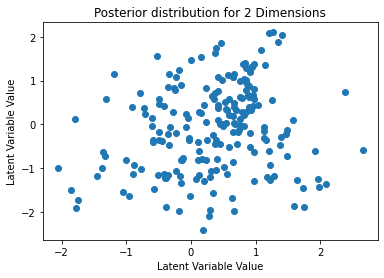

In [47]:
def generate_predictions(model, test_loader):
    model.eval()
    N_samples = len(test_loader)
    latend_space = torch.zeros((N_samples, 3))
    ground_truths = torch.zeros((N_samples, 3))
    with torch.no_grad():
        for i, (input, ground_truth) in enumerate(test_loader):
            z, _ = model(input, ground_truth)
            latend_space[i] = z
            ground_truths[i] = ground_truth
    return latend_space.numpy(), ground_truths.numpy()


test_dataset = SIRDataset(size=200, T=100)
test_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

latend_space, _ = generate_predictions(model=model, test_loader=test_loader)
plt.scatter(latend_space[:, 0], latend_space[:, 1])
plt.title('Posterior distribution for 2 Dimensions')
plt.xlabel('Latent Variable Value')
plt.ylabel('Latent Variable Value')

plt.show()

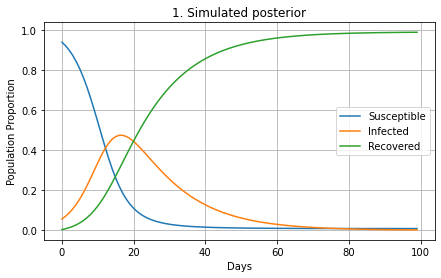

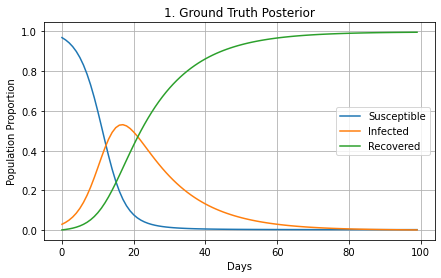

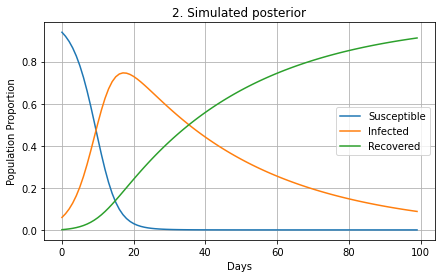

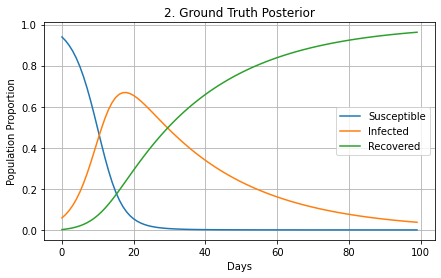

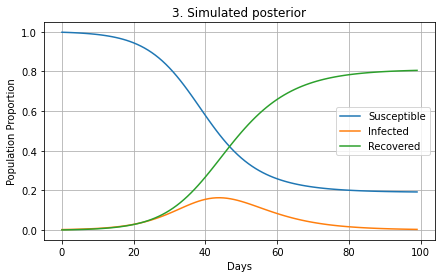

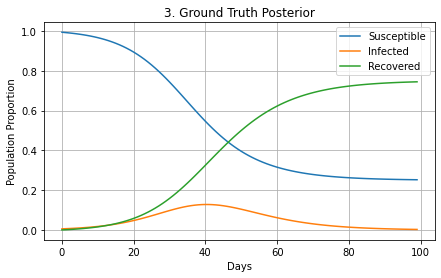

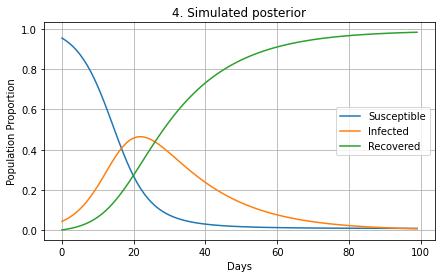

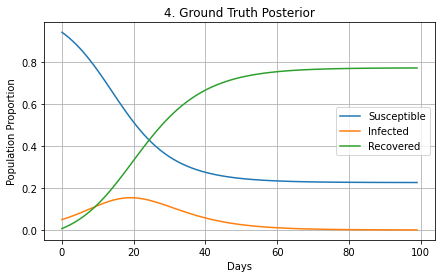

In [48]:
test_dataset = SIRDataset(size=10, T=100)
for i in range(4):
    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    ground_truth = ground_truth.unsqueeze(0)
    with torch.no_grad():
        posterior = model.sample_posterior(input, 1)
    posterior = posterior.squeeze(0).numpy()
    ground_truth = ground_truth.squeeze(0).numpy()

    _, C = simulate_sir_simple(posterior[0], posterior[1], posterior[2], num_days)
    _, C_truth = simulate_sir_simple(
        ground_truth[0], ground_truth[1], ground_truth[2], num_days)

    plot_sir_simulation(C, title=f'{i+1}. Simulated posterior')
    plot_sir_simulation(C_truth, title=f'{i+1}. Ground Truth Posterior')

We see, while looking at 4 different test samples, the network is able to predict values that resemble the ground truth values. Lets now take a look at the actual posterior distribution

## 1.5

In [11]:
def plot_empirical_cdf(samples_posterior,ground_truth, bins = 50):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    parameter = ['lambda', 'mu', 'I_0']
    for i in range(len(parameter)):
        single_posterior = samples_posterior[:,i]
        truth = ground_truth[i]

        single_posterior = np.sort(single_posterior)
        counts, bin_edges = np.histogram(single_posterior, bins=bins, density=True)
        cdf = np.cumsum(counts) * np.diff(bin_edges)

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        axs[i].plot(bin_centers, cdf, label='Empirical CDF')
        axs[i].axvline(x=truth, color='r', linestyle='--', label='Ground Truth')
        axs[i].set_xlabel('Sample Values')
        axs[i].set_ylabel('Cumulative Probability')
        axs[i].set_title(f'Empirical CDF for {parameter[i]} Samples')
        axs[i].legend()
    plt.show()

def plot_histograms(samples_posterior,ground_truth, bins = 50):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    parameter = ['lambda', 'mu', 'I_0']
    for i in range(len(parameter)):
        single_posterior = samples_posterior[:,i]
        truth = ground_truth[i]
        axs[i].hist(single_posterior, bins=bins, alpha=0.7, color='blue')
        axs[i].axvline(x=truth, color='r',linestyle='--', label="ground truth")
        axs[i].set_title(f'{parameter[i]} Latent Space Variables')
        axs[i].set_xlabel('Latent Variable Value')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
    plt.show()

X Test Sample 1


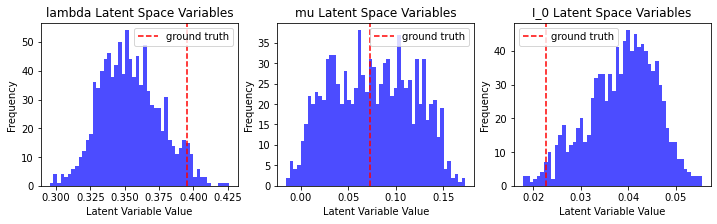

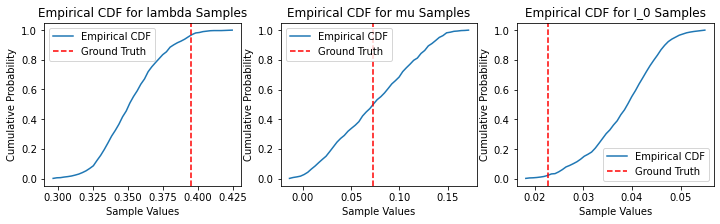

X Test Sample 2


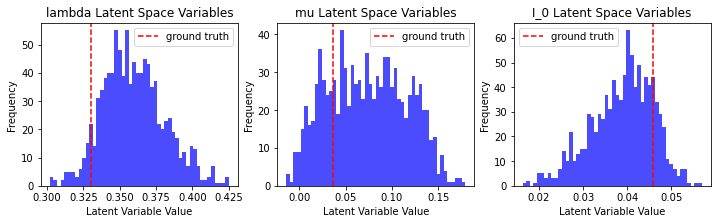

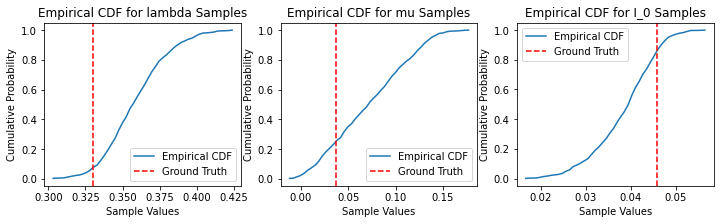

X Test Sample 3


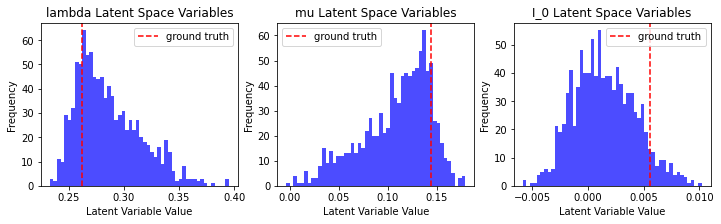

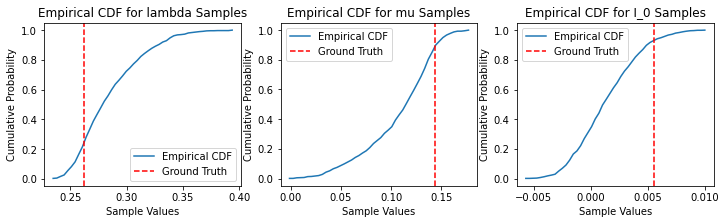

X Test Sample 4


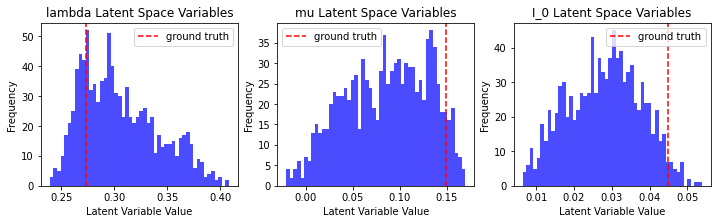

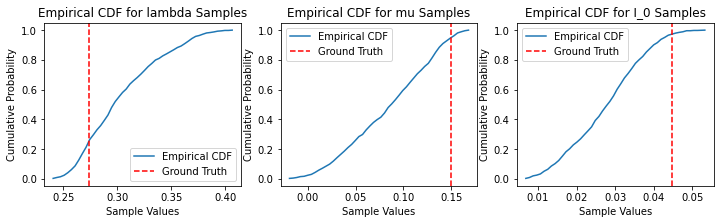

In [50]:
for i in range(4):

    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    ground_truth = ground_truth.unsqueeze(0)
    n_samples = 1000
    with torch.no_grad():
        samples_posterior = model.sample_posterior(input, n_samples)
    samples_posterior = samples_posterior.numpy()
    ground_truth = ground_truth.squeeze(0).numpy()
    print(f'X Test Sample {i+1}')

    plot_histograms(samples_posterior=samples_posterior,
                    ground_truth=ground_truth,
                    bins=50)

    plot_empirical_cdf(samples_posterior=samples_posterior,
                       ground_truth=ground_truth,
                       bins=50)




    plt.show()

The marginal distribution are look mostly good calibrated. We see the worst performance in lambda values at Test samples 1 and 2

## 1.6

In [51]:
for i in range(4):

    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    ground_truth = ground_truth.unsqueeze(0)
    with torch.no_grad():
        samples_posterior = model.sample_posterior(input, 200)
    samples_posterior = samples_posterior.numpy()
    ground_truth = ground_truth.squeeze(0).numpy()
    print(f'X Test Sample {i+1}')
    n_samples = len(samples_posterior)
    T = 100
    C_k = np.zeros((n_samples,T,3))
    for j in range(len(samples_posterior)):
        _, C = simulate_sir_simple(lam=samples_posterior[j,0],
                            mu=samples_posterior[j,1],
                            I_0=samples_posterior[j,2],
                            T=T)
        C_k[j,:,:] = C
    lower_bound = np.percentile(C_k, 2.5, axis=0)
    upper_bound = np.percentile(C_k, 97.5, axis=0)
    _, ground_truth_C = simulate_sir_simple(lam=ground_truth[0],
                            mu=ground_truth[1],
                            I_0=ground_truth[2],
                            T=T)
    is_within_interval = (lower_bound <= ground_truth_C) & (ground_truth_C <= upper_bound)
    is_C_in_intervall = np.all(is_within_interval)
    print(f'Ground Truth C is in predicted Confidence Intervall: {is_C_in_intervall}')


X Test Sample 1
Ground Truth C is in predicted Confidence Intervall: False
X Test Sample 2
Ground Truth C is in predicted Confidence Intervall: True
X Test Sample 3
Ground Truth C is in predicted Confidence Intervall: True
X Test Sample 4
Ground Truth C is in predicted Confidence Intervall: False


# 2. Noisy data


In [15]:
import numpy as np

class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers, output_size=3):# output_size=3 (default) for no noise case
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, output_size))  # Output layer

        # Register the layer list as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

def simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T):
    """
    Simulates the epidemic with multiplicative noise in the observations using the Euler forward scheme up to day T.
    lam = infection rate
    mu = recovery rate
    I_0 = initial percentage of infected people
    L = time lag for noise
    rho = mean of the noise distribution
    sigma_2 = variance of the noise distribution
    T = days to simulate
    """
    # Initialize variables
    S = 1.0 - I_0
    I = I_0
    R = 0.0

    # Lists to store observations and ODE variables
    X_noisy = np.zeros((T, 2))
    X_no_delay = np.zeros((T,2))
    C_noisy = np.zeros((T, 3))

    for day in range(T):
        # Ensure variables are within bounds
        S = max(min(S, 1.0), 0.0)
        I = max(min(I, 1.0), 0.0)
        R = max(min(R, 1.0), 0.0)

        # Check for population total exceeding 1 due to numerical error
        if S + I + R > 1.0:
            excess = S + I + R - 1.0
            S -= excess * S / (S + I + R)
            I -= excess * I / (S + I + R)
            R -= excess * R / (S + I + R)

        # Calculate new values using Euler forward scheme
        new_infections = lam * S * I
        dS = -new_infections
        dI = new_infections - mu * I
        dR = mu * I

        S += dS
        I += dI
        R += dR

        # Append current values to the lists
        X_no_delay[day] = [dS, dR]
        #X_noisy[day]= [0,0]
        C_noisy[day] = [S, I, R]

        # Introduce multiplicative noise with reporting delay
        if day >= L:
            # eps_s=np.random.normal(rho, np.sqrt(sigma_2))
            # eps_r=np.random.normal(rho, np.sqrt(sigma_2))
            delayed_dS = X_no_delay[day - L, 0] #* eps_s  # dS(t - L) with noise
            delayed_dR = X_no_delay[day - L, 1] #* eps_r  # dR(t - L) with noise
            X_noisy[day] = [delayed_dS, delayed_dR]


        ### Adding multiplicative noise:
        eps_s=np.random.normal(rho, np.sqrt(sigma_2))
        eps_i= np.random.normal(rho, np.sqrt(sigma_2))
        eps_r=np.random.normal(rho, np.sqrt(sigma_2))
        X_noisy[day]= [eps_s*X_noisy[day][0], eps_r* X_noisy[day][1]]
        C_noisy[day] = [S*eps_s, I*eps_i, R*eps_r]  # this will change!

    return X_noisy, X_no_delay, C_noisy#


2.1. Visualising and comparing the noiseless and noisy outcomes.

plotting $\Delta S$ and $\Delta R$

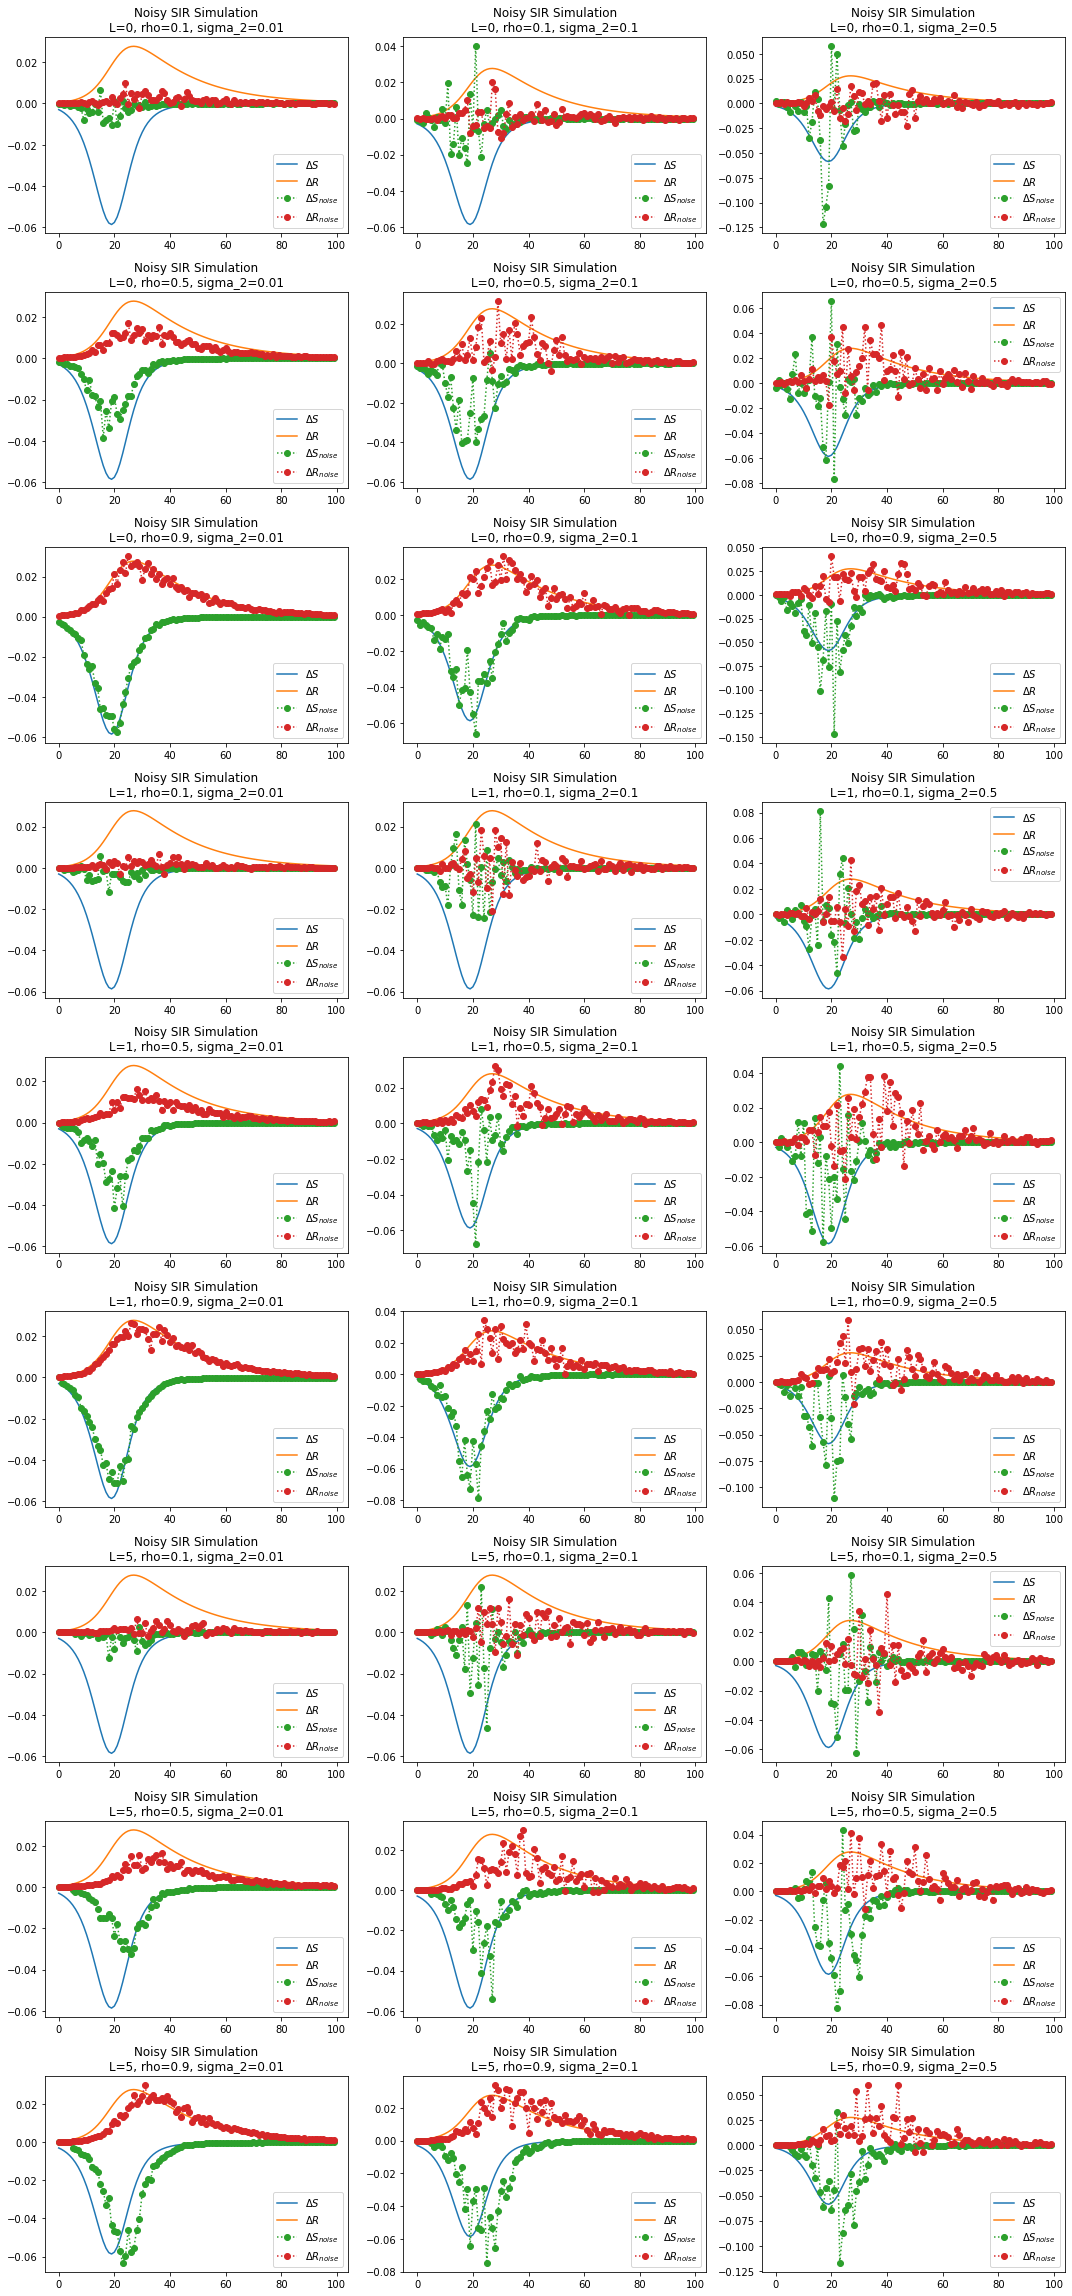

In [16]:
import matplotlib.pyplot as plt

# Define parameters
lam = 0.3  # infection rate
mu = 0.05   # recovery rate
I_0 = 0.01  # initial percentage of infected people
T = 100    # days to simulate

### we will consider low, mid and high values of L, rho and sigma^2.
L_values = [0, 1, 5]  # reporting delay values
rho_values = [0.1, 0.5, 0.9]  # underreporting fraction values
sigma_2_values = [0.01, 0.1, 0.5]  # reporting error variance values

# Plot noise-free outcome
X, C = simulate_sir_simple(lam, mu, I_0, T)
# S_simple, I_simple, R_simple = X[:, 0], X[:, 1], X[:, 2]
S_simple, R_simple = X[:, 0], X[:, 1]
# plot_sir_simulation(C,title="noise_free")

# # Plot noisy outcomes for different parameter ranges

# Create subplots
fig, axes = plt.subplots(9, 3, figsize=(15, 32))

# Plot noisy outcomes for different parameter ranges
subplot_count = 0

for i, L in enumerate(L_values):
    for j, rho in enumerate(rho_values):
        for k, sigma_2 in enumerate(sigma_2_values):
            X_noise, X_no_del, C_noise = simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T)


            # Explicitly create subplot using axes
            ax = axes[subplot_count // 3, subplot_count % 3]
            S, R = X_noise[:, 0], X_noise[:, 1]
            ax.plot(range(T), S_simple, label=r"$\Delta S$")
            #ax.plot(range(T), I_simple, label=f"I")
            ax.plot(range(T), R_simple, label=r"$\Delta R$")


            ax.plot(range(T), S, "o:",label=r"$\Delta S_{noise}$")
            #ax.plot(range(T), I,"o:", label=f"I_noise")
            ax.plot(range(T), R, "o:",label=r"$\Delta R_{noise}$")
            ax.set_title(f"Noisy SIR Simulation\nL={L}, rho={rho}, sigma_2={sigma_2}")
            ax.legend()


            # Increment subplot_count
            subplot_count += 1

    # print("Snoisy is")
    # print(X_noise[:,0])
    # print("S no delay is:")
    # print(X_no_delay[:,0])

# Explicitly remove overlapping axes
for i in range(subplot_count, 4 * 2):
    fig.delaxes(axes[i // 2, i % 2])

plt.tight_layout()
plt.show()




From the results above, we decided to choose the following range of values:

* L in [0,5]. ( we consider a maximum of 1 week delay)
* rho in the range [0.5,1)
* sigma_2 in the range [0.02, 0.2]

let's see some plots for these ranges.

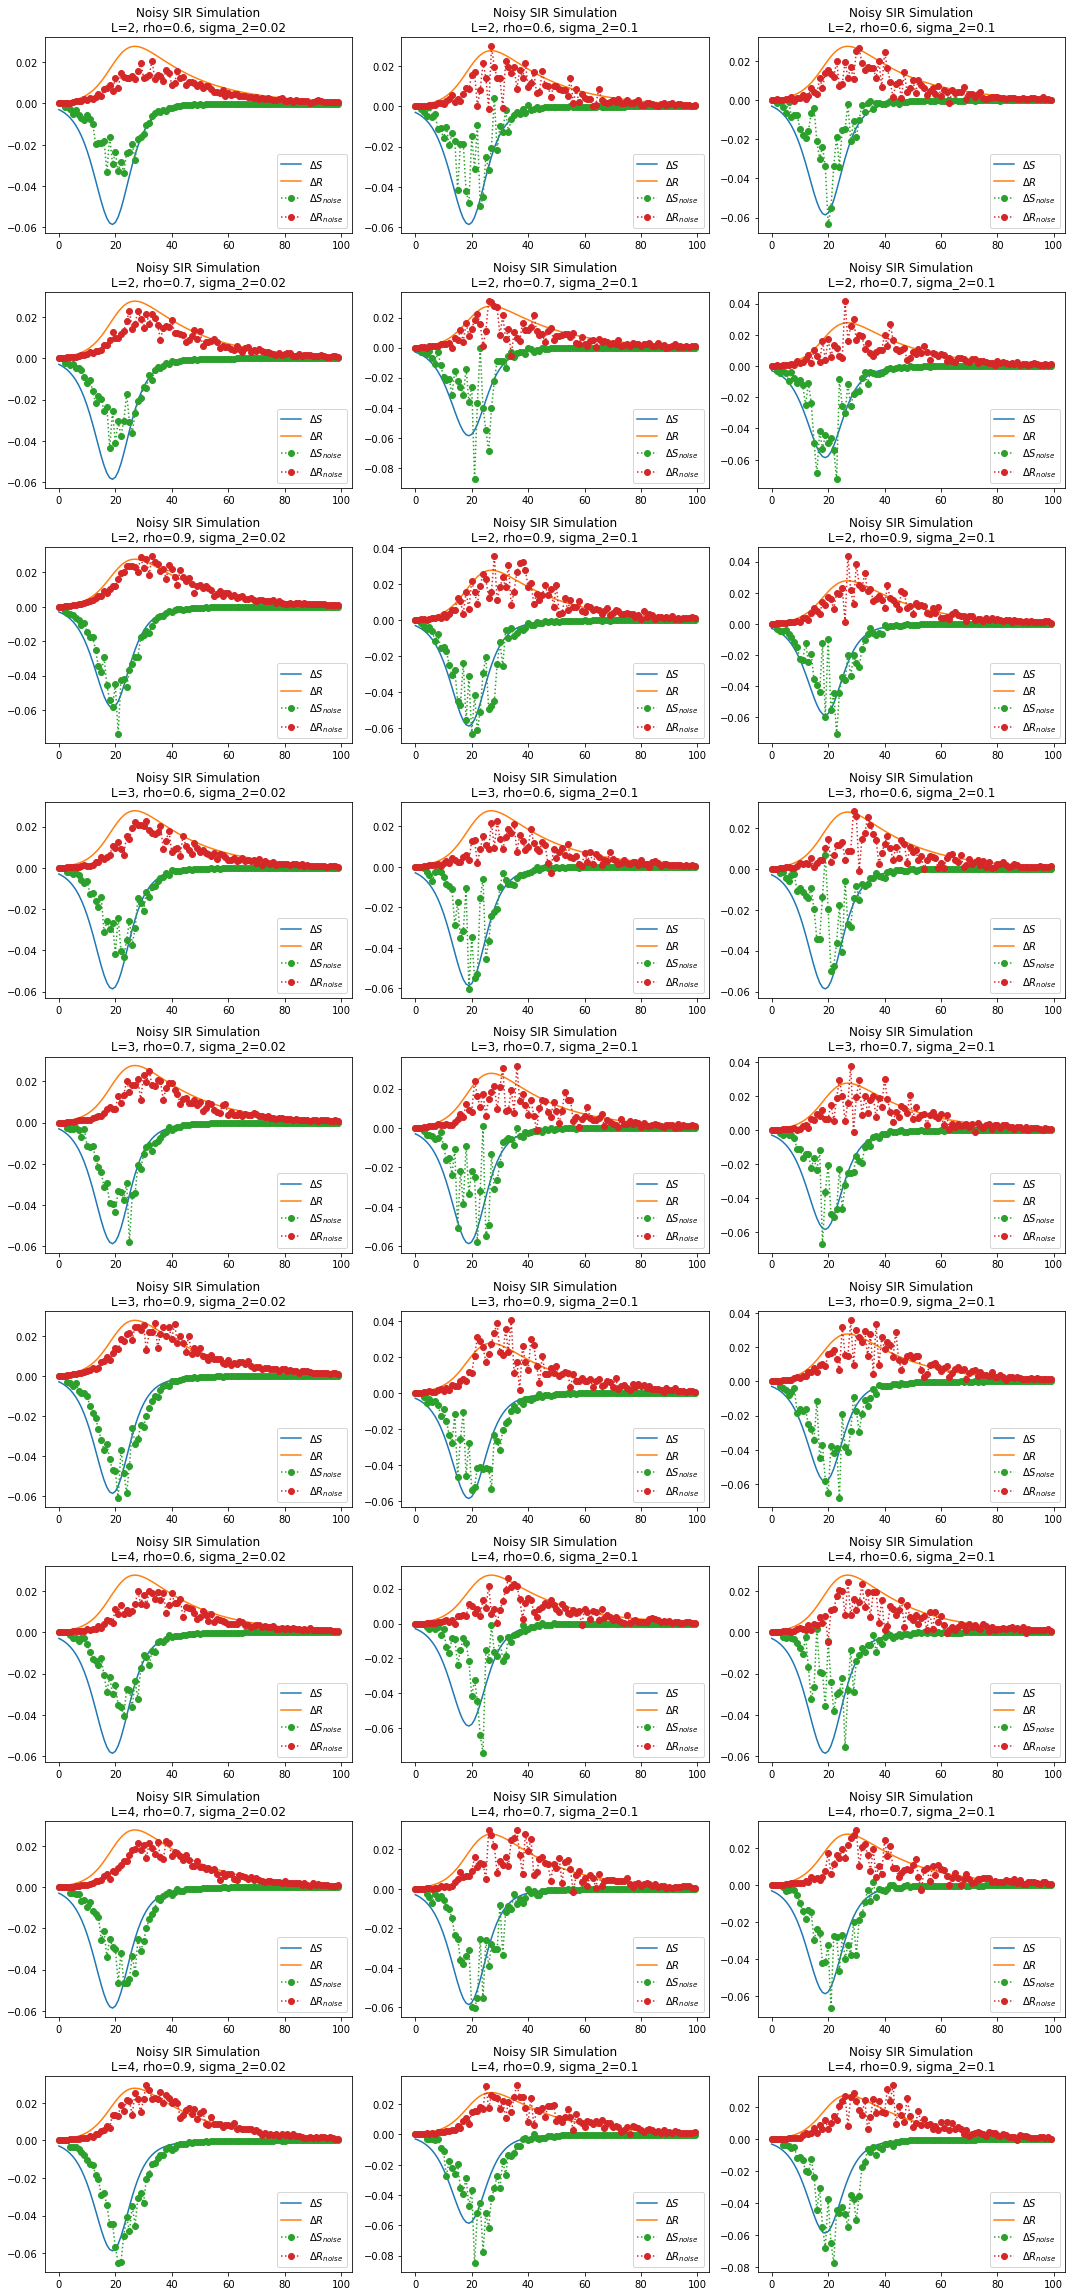

In [17]:
import matplotlib.pyplot as plt

# Define parameters
lam = 0.3  # infection rate
mu = 0.05   # recovery rate
I_0 = 0.01  # initial percentage of infected people
T = 100    # days to simulate

### we will consider low, mid and high values of L, rho and sigma^2.
L_values = [2,3,4]  # reporting delay values
rho_values = [0.6, 0.7, 0.9]  # underreporting fraction values
sigma_2_values = [0.02, 0.1, 0.1]  # reporting error variance values

# Plot noise-free outcome
X, C = simulate_sir_simple(lam, mu, I_0, T)
# S_simple, I_simple, R_simple = X[:, 0], X[:, 1], X[:, 2]
S_simple, R_simple = X[:, 0], X[:, 1]
# plot_sir_simulation(C,title="noise_free")

# # Plot noisy outcomes for different parameter ranges

# Create subplots
fig, axes = plt.subplots(9, 3, figsize=(15, 32))

# Plot noisy outcomes for different parameter ranges
subplot_count = 0

for i, L in enumerate(L_values):
    for j, rho in enumerate(rho_values):
        for k, sigma_2 in enumerate(sigma_2_values):
            X_noise, X_no_del, C_noise = simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T)


            # Explicitly create subplot using axes
            ax = axes[subplot_count // 3, subplot_count % 3]
            S, R = X_noise[:, 0], X_noise[:, 1]
            ax.plot(range(T), S_simple, label=r"$\Delta S$")
            #ax.plot(range(T), I_simple, label=f"I")
            ax.plot(range(T), R_simple, label=r"$\Delta R$")


            ax.plot(range(T), S, "o:",label=r"$\Delta S_{noise}$")
            #ax.plot(range(T), I,"o:", label=f"I_noise")
            ax.plot(range(T), R, "o:",label=r"$\Delta R_{noise}$")
            ax.set_title(f"Noisy SIR Simulation\nL={L}, rho={rho}, sigma_2={sigma_2}")
            ax.legend()


            # Increment subplot_count
            subplot_count += 1

    # print("Snoisy is")
    # print(X_noise[:,0])
    # print("S no delay is:")
    # print(X_no_delay[:,0])

# Explicitly remove overlapping axes
for i in range(subplot_count, 4 * 2):
    fig.delaxes(axes[i // 2, i % 2])

plt.tight_layout()
plt.show()

* Extending our prior $p^{sim}(Y)$ accordingly:

In [18]:
import random
class SIRDataset_noisy(Dataset):
    def __init__(self, size, T):
        self.size = size
        self.T = T
        self.data = []
        self.targets = []

        lam_prior = np.random.uniform(0.25, 0.4, size=size)
        mu_prior = np.random.uniform(0.01, 0.15, size=size)
        I_0_prior = np.random.uniform(0.0001, 0.05, size=size)
        ### adding noise params' prior
        rho_prior= np.random.uniform(0.5,1,size=size)
        sigma_2_prior= np.random.uniform(0.02,0.2, size=size)
        L_prior=random_integers = [random.randint(1, 5) for _ in range(size)]

        for i in range(size):
            lam = lam_prior[i]
            mu = mu_prior[i]
            I_0 = I_0_prior[i]
            L= L_prior[i]
            rho=rho_prior[i]
            sigma_2=sigma_2_prior[i]

            # getting the noisy outputs
            X, _, _ = simulate_sir_noisy(lam, mu, I_0,L, rho, sigma_2, T)# X_noisy, X_no_delay, C_noisy
            self.data.append(X)
            self.targets.append([lam, mu, I_0, L, rho, sigma_2])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

To our feature detection network to accommodate for additional number of parameters: Can easily be achieved by simply setting `output_size = 6` argument while instantiating the SIRNet model for the case of noisy SIR!

* Creating the dataloaders for the noisy SIR case

In [19]:
train_dataset_noisy = SIRDataset_noisy(size=1000, T=100)
validation_dataset_noisy = SIRDataset_noisy(size=200, T=100)
test_dataset_noisy = SIRDataset_noisy(size=200, T=100)
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=32, shuffle=True)
validation_loader_noisy = DataLoader(validation_dataset_noisy, batch_size=32, shuffle=True)
test_loader_noisy = DataLoader(validation_dataset_noisy, batch_size=32, shuffle=True)
criterion = nn.MSELoss()

### 2.3 training just the `h(x)` to predict the parameters!

[0/20] train loss: 1.8223625421524048, validation loss: 1.6800087520054408
[1/20] train loss: 1.5659144688397646, validation loss: 1.3471255472728185
[2/20] train loss: 1.188953561708331, validation loss: 0.9633232440267291
[3/20] train loss: 0.8361898232251406, validation loss: 0.6820923600878034
[4/20] train loss: 0.5692671705037355, validation loss: 0.48194410119737896
[5/20] train loss: 0.4147521904669702, validation loss: 0.3860412282603128
[6/20] train loss: 0.3624922353774309, validation loss: 0.36277269039835247
[7/20] train loss: 0.34382681688293815, validation loss: 0.3591827026435307
[8/20] train loss: 0.34036132134497166, validation loss: 0.3485803008079529
[9/20] train loss: 0.3377783647738397, validation loss: 0.345515957900456
[10/20] train loss: 0.33306349301710725, validation loss: 0.36992279972348896
[11/20] train loss: 0.32902083871886134, validation loss: 0.33041887836796896
[12/20] train loss: 0.33214536076411605, validation loss: 0.3330217386995043
[13/20] train l

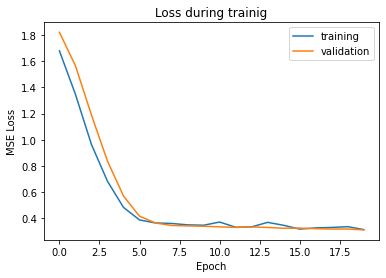

In [20]:
noisy_case_feature_detect_net=SIRNet(input_size=100*2, hidden_size=50, n_hidden_layers=0, output_size=6)
optimizer = optim.Adam(noisy_case_feature_detect_net.parameters(), lr=0.001)

train_loss, validation_loss =  train_network(
    noisy_case_feature_detect_net,train_loader_noisy, validation_loader_noisy, optimizer, criterion, epochs=20)
plot_losses(train_loss, validation_loss)
plt.title("Loss during trainig")
plt.legend()
plt.show()

lets try different hidden layers and different sizes

-------------number of layers=0 and hidden size= 50-----------
[0/20] train loss: 1.7656048685312271, validation loss: 1.6829607827322823
[1/20] train loss: 1.505042189732194, validation loss: 1.3857967683247157
[2/20] train loss: 1.1457837261259556, validation loss: 0.992183940751212
[3/20] train loss: 0.8192140311002731, validation loss: 0.6549208462238312
[4/20] train loss: 0.5296709444373846, validation loss: 0.43711415358952116
[5/20] train loss: 0.3817823356948793, validation loss: 0.3540104627609253
[6/20] train loss: 0.32820981135591865, validation loss: 0.3410107025078365
[7/20] train loss: 0.31799503415822983, validation loss: 0.2997741603425571
[8/20] train loss: 0.3111414830200374, validation loss: 0.312960935490472
[9/20] train loss: 0.30848955269902945, validation loss: 0.3148354526076998
[10/20] train loss: 0.3026514006778598, validation loss: 0.3017837277480534
[11/20] train loss: 0.303301943000406, validation loss: 0.30684393644332886
[12/20] train loss: 0.295167708303

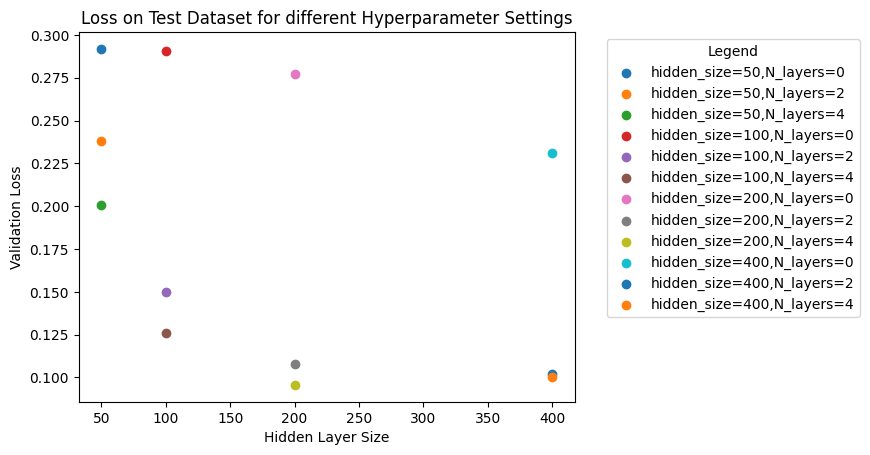

In [ ]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [50, 100, 200, 400]

for hidden_size in HIDDEN_SIZES:
  for n_layer in N_LAYERS:
      print(f"-------------number of layers={n_layer} and hidden size= {hidden_size}-----------")
      net = SIRNet(input_size=100*2, hidden_size=hidden_size,
                    n_hidden_layers=n_layer, output_size=6)
      optimizer = optim.Adam(net.parameters(), lr=0.001)

      _, validation_loss = train_network(
          net, train_loader_noisy, validation_loader_noisy, optimizer, criterion, epochs=20)

      test_loss= evaluate_network(net, test_loader_noisy, criterion)
      plt.scatter(hidden_size, test_loss, label= f"hidden_size={hidden_size},N_layers={n_layer}")

plt.xlabel('Hidden Layer Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')
# Move the legend outside the plot using bbox_to_anchor
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

plt.title('Loss on Test Dataset for different Hyperparameter Settings')
plt.show()

* Once again we see that the larger the network the better. just like the case of noise-free, we proceed with the choice: number of layers=4 and hidden_size of 400!

* Let's look into the variable dataset sizes

------- for train_size=500-----------
[0/20] train loss: 1.0857163593173027, validation loss: 0.3568233294146402
[1/20] train loss: 0.3987513370811939, validation loss: 0.3147960432938167
[2/20] train loss: 0.357460618019104, validation loss: 0.2923093523297991
[3/20] train loss: 0.3499444294720888, validation loss: 0.3336325202669416
[4/20] train loss: 0.3336069891229272, validation loss: 0.2721517873661859
[5/20] train loss: 0.32373268250375986, validation loss: 0.2731772767645972
[6/20] train loss: 0.31134780310094357, validation loss: 0.2628159693309239
[7/20] train loss: 0.30173404794186354, validation loss: 0.26231429619448526
[8/20] train loss: 0.2848872970789671, validation loss: 0.23567132226058415
[9/20] train loss: 0.28050908353179693, validation loss: 0.24970915062086924
[10/20] train loss: 0.27231547981500626, validation loss: 0.23105336725711823
[11/20] train loss: 0.2493689674884081, validation loss: 0.25069551382746014
[12/20] train loss: 0.2530644126236439, validation 

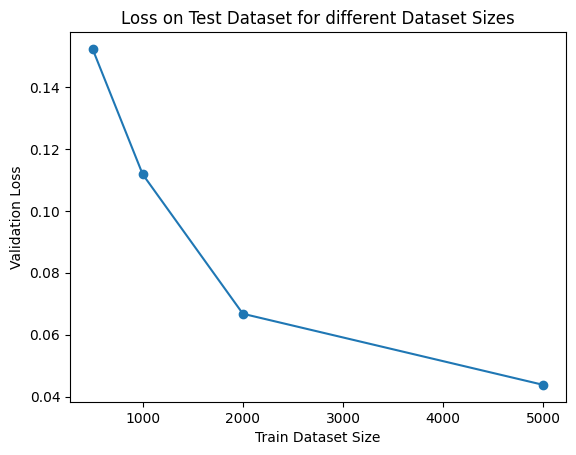

In [ ]:
trainset_sizes = [500, 1000, 2000, 5000]
test_losses = []
for train_size in trainset_sizes:
    print(f"------- for train_size={train_size}-----------")
    train_dataset = SIRDataset_noisy(size=train_size, T=100)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


    net = SIRNet(input_size=100*2, hidden_size=400, n_hidden_layers=4, output_size=6)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    _, _ = train_network(
        net, train_loader, validation_loader_noisy, optimizer, criterion, 20)
    test_loss = evaluate_network(net, test_loader_noisy, criterion)
    test_losses.append(test_loss)


plt.plot(trainset_sizes, test_losses, "o-")

plt.xlabel('Train Dataset Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')

plt.title('Loss on Test Dataset for different Dataset Sizes')
plt.show()

After a few dry runs, we decided to continue with the dataset size of 2000.

### 2.4 let's now use the conditional INN for the case of noisy dataset

In [21]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers, feature_size):# output_size=3 (default) for no noise case
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, feature_size))

        # Register the layer list as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

In [22]:
### DEFINING OUR CINN model

def subnet_constructor(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    return model


def ortogonal_matrix(dim):
    Q = special_ortho_group.rvs(dim)
    return torch.Tensor(Q)


class ConditionalCouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1
        self.subnet = subnet_constructor(
            self.split1 + self.condition_size, self.hidden_size, 2*self.split2)

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]

        params = self.subnet(torch.cat([x1, cond], -1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)

        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1, x2], -1), ljd
        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1, x2], -1)


class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.condition_size = condition_size

        self.coupling_blocks = nn.ModuleList([ConditionalCouplingBlock(
            input_size, hidden_size, self.condition_size) for _ in range(n_blocks)])
        self.orthogonal_matrices = [ortogonal_matrix(
            input_size) for _ in range(n_blocks-1)]

    def forward(self, x, cond, rev=False):
        if rev:
            return self._inverse(x, cond)
        return self._forward(x, cond)

    def _forward(self, x, cond):
        ljd = torch.zeros((x.shape[0]))
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x, cond)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x, cond)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x, cond):
        for l in range(self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        samples = []
        if cond is None:
            for c in range(self.condition_size):
                z = torch.normal(mean=torch.zeros(
                    (num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
                samples.append(self._inverse(z, cond=c.repeat(num_samples, 1)))
        else:
            z = torch.normal(mean=torch.zeros(
                (num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
            samples.append(self._inverse(z, cond=cond.repeat(num_samples, 1)))
        return torch.cat(samples, 0)

In [23]:
# conditional real NVP class
class FusionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size_sir, feature_size, n_layers_sir, hidden_size_nvp, input_size_nvp, blocks):
        super(FusionNetwork, self).__init__()

        self.feature_size = feature_size

        self.summary_net = SIRNet(input_size=input_size,
                                  hidden_size=hidden_size_sir,
                                  n_hidden_layers=n_layers_sir,
                                  feature_size=feature_size)

        self.real_nvp = ConditionalRealNVP(input_size=input_size_nvp,
                                           hidden_size=hidden_size_nvp,
                                           n_blocks=blocks,
                                           condition_size=feature_size)

    def forward(self, x, y):
        condition = self.summary_net(x)
        x = self.real_nvp(y, condition)
        return x

    def sample_posterior(self, x, num_samples):
        condition = self.summary_net(x)
        return self.real_nvp.sample(num_samples=num_samples, cond=condition)

In [24]:
def training_per_epoch(model, train_loader, optimizer, batchsize):
    model.train()
    loss_sum = 0
    for input, ground_truth in train_loader:
        optimizer.zero_grad()
        z, ljd = model(input, ground_truth)
        loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum/len(train_loader)


def validation_per_epoch(model, validation_loader, batchsize):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for input, ground_truth in validation_loader:
            z, ljd = model(input, ground_truth)
            loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
            loss_sum += loss.item()
    return loss_sum/len(validation_loader)


def train_fusion(model, train_loader, validation_loader, batchsize=32, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = training_per_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer, batchsize=batchsize)
        validation_loss = validation_per_epoch(
            model=model, validation_loader=validation_loader, batchsize=batchsize)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss}")

    return train_losses, validation_losses

In [25]:
params = {'input_size': 2*100,
          'hidden_size_sir': 200,
          'feature_size': 50,
          'n_layers_sir': 4,
          'hidden_size_nvp': 200,
          'input_size_nvp': 6,# i think this is what would change now in our case
          'blocks': 10}

train_dataset = SIRDataset_noisy(size=2000, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = FusionNetwork(**params)
train_loss_noise, val_loss_noise=train_fusion(model, train_loader, validation_loader_noisy, epochs=50)

Epoch [1/50], Train Loss: -7.1837, Validation Loss: -10.00637936592102
Epoch [2/50], Train Loss: -11.3574, Validation Loss: -9.526300123759679
Epoch [3/50], Train Loss: -11.7740, Validation Loss: -10.767488139016288
Epoch [4/50], Train Loss: -12.1209, Validation Loss: -11.344244003295898
Epoch [5/50], Train Loss: -12.5585, Validation Loss: -11.672597101756505
Epoch [6/50], Train Loss: -12.7246, Validation Loss: -11.80759859085083
Epoch [7/50], Train Loss: -12.0389, Validation Loss: -10.941061088017054
Epoch [8/50], Train Loss: -12.8256, Validation Loss: -11.929188966751099
Epoch [9/50], Train Loss: -13.1177, Validation Loss: -11.548209496906825
Epoch [10/50], Train Loss: -13.1343, Validation Loss: -11.147615160260882
Epoch [11/50], Train Loss: -13.1199, Validation Loss: -12.012079511369977
Epoch [12/50], Train Loss: -13.4139, Validation Loss: -11.628282274518694
Epoch [13/50], Train Loss: -13.4017, Validation Loss: -12.295522689819336
Epoch [14/50], Train Loss: -13.5371, Validation Los

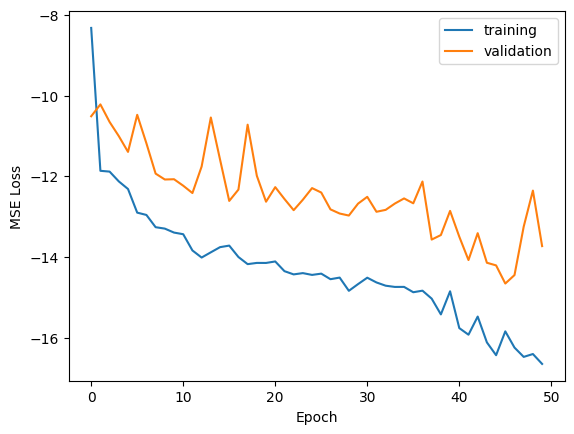

In [ ]:
plot_losses(validation_loss=val_loss_noise, train_loss=train_loss_noise)
plt.legend()
plt.show()

In [ ]:
test_dataset = SIRDataset_noisy(size=10, T=100)

posterior_list=[]
ground_truth_list=[]
for i in range(10):
    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    ground_truth = ground_truth.unsqueeze(0)
    with torch.no_grad():
        posterior = model.sample_posterior(input, 1)
    posterior = posterior.squeeze(0).numpy()
    posterior_list.append(posterior)
    ground_truth = ground_truth.squeeze(0).numpy()
    ground_truth_list.append(ground_truth)

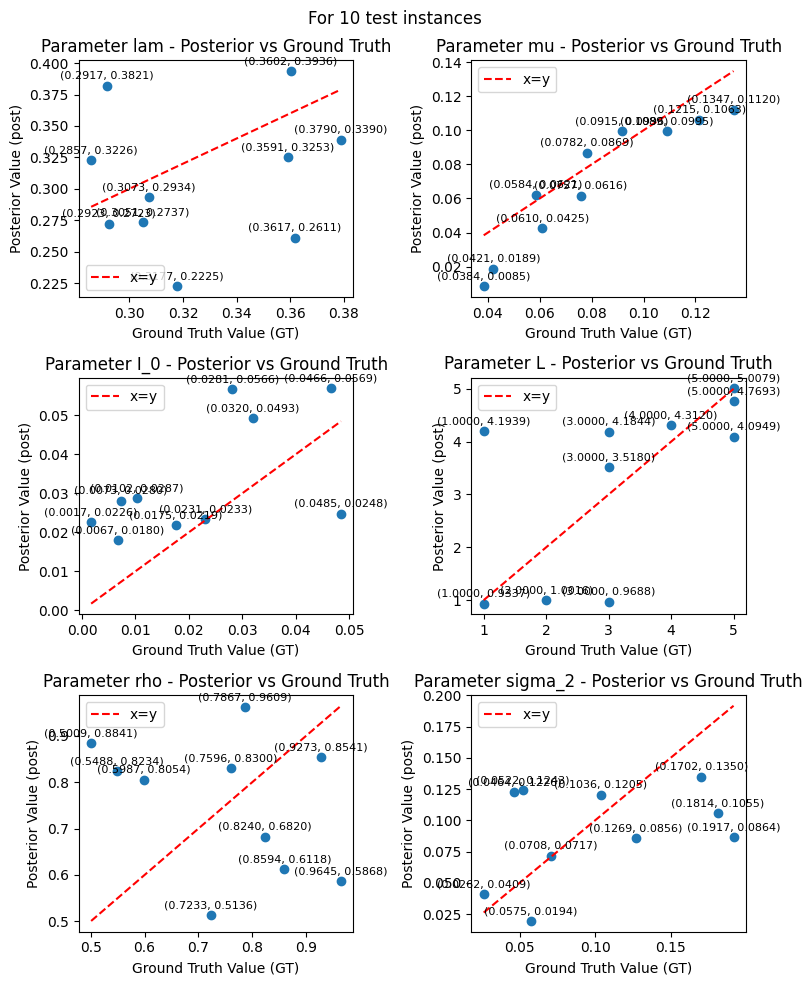

In [ ]:

# Creating 3x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
param_names=['lam', 'mu', 'I_0', 'L', 'rho', 'sigma_2']

for j in range(6):  # Loop over parameters (assuming 6 parameters)
    ax = axes[j // 2, j % 2]

    # Scatter plot
    scatter = ax.scatter(np.array(ground_truth_list)[:, j], np.array(posterior_list)[:, j])

    # Plotting the dashed line x=y
    ax.plot([min(np.array(ground_truth_list)[:, j]), max(np.array(ground_truth_list)[:, j])],
            [min(np.array(ground_truth_list)[:, j]), max(np.array(ground_truth_list)[:, j])],
            linestyle='--', color='red', label='x=y')

    ax.set_title(f'Parameter {param_names[j]} - Posterior vs Ground Truth')
    ax.set_xlabel('Ground Truth Value (GT)')
    ax.set_ylabel('Posterior Value (post)')
    ax.legend()

    # Adding annotations with a consistent color
    for i in range(10):
        ax.annotate(f'({ground_truth_list[i][j]:.4f}, {posterior_list[i][j]:.4f})',
                    (ground_truth_list[i][j], posterior_list[i][j]),
                    textcoords="offset points",
                    xytext=(0, 5),
                    ha='center',
                    fontsize=8,
                    color='black')


plt.suptitle("For 10 test instances")

plt.tight_layout()
plt.show()


In [ ]:
### we can check what we have plotted, let's consider the (3,6) subplot:
sixth_param_list=[]
for i in range(0,10):
  sixth_param_list.append((ground_truth_list[i][5],posterior_list[i][5]))

# Sort the list of tuples based on the first values
sorted_data = sorted(sixth_param_list, key=lambda x: x[0])

# Print the sorted list
for item in sorted_data:
    print(item)# these are what we have plotted there!

(0.026163187, 0.040897973)
(0.04640774, 0.12262823)
(0.052189026, 0.124252945)
(0.057467785, 0.019444326)
(0.07084962, 0.07165576)
(0.103589356, 0.120497)
(0.12690152, 0.085558124)
(0.17017722, 0.13497046)
(0.18135123, 0.10551441)
(0.19165471, 0.086399004)


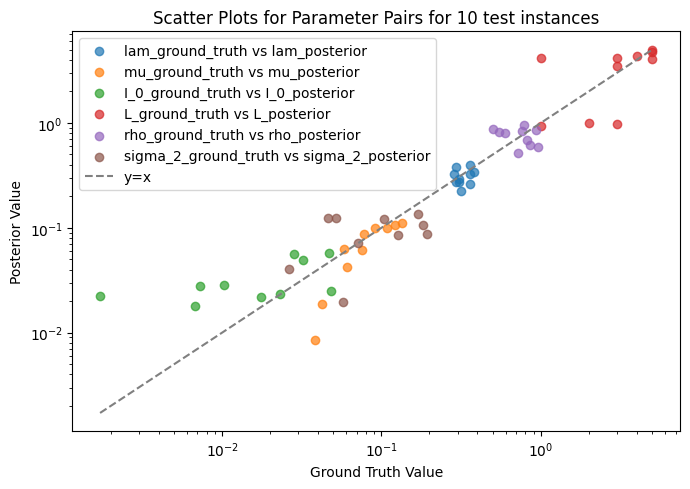

In [ ]:
# Creating a single plot
fig, ax = plt.subplots(figsize=(7, 5))

param_names = ['lam', 'mu', 'I_0', 'L', 'rho', 'sigma_2']

# Loop over parameter pairs
for i in range(6):
    # Scatter plot for parameter pair (i, i) - same type of feature
    ax.scatter(np.array(ground_truth_list)[:, i], np.array(posterior_list)[:, i],
               label=f'{param_names[i]}_ground_truth vs {param_names[i]}_posterior', alpha=0.7)

# Plotting the y=x line
ax.plot([min(np.array(ground_truth_list).min(), np.array(posterior_list).min()),
         max(np.array(ground_truth_list).max(), np.array(posterior_list).max())],
        [min(np.array(ground_truth_list).min(), np.array(posterior_list).min()),
         max(np.array(ground_truth_list).max(), np.array(posterior_list).max())],
        linestyle='--', color='gray', label='y=x')

# Adding a legend
ax.legend()

# Adding labels and title
ax.set_xlabel('Ground Truth Value')
ax.set_ylabel('Posterior Value')
ax.set_title('Scatter Plots for Parameter Pairs for 10 test instances')

# Setting log scale
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### 2.6 checking the posterior predictive calibration by resimulation

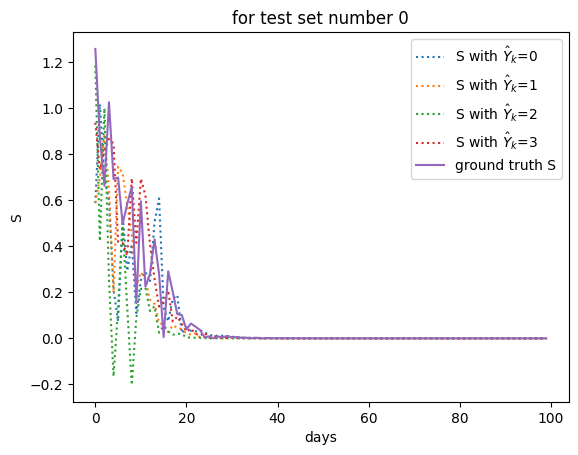

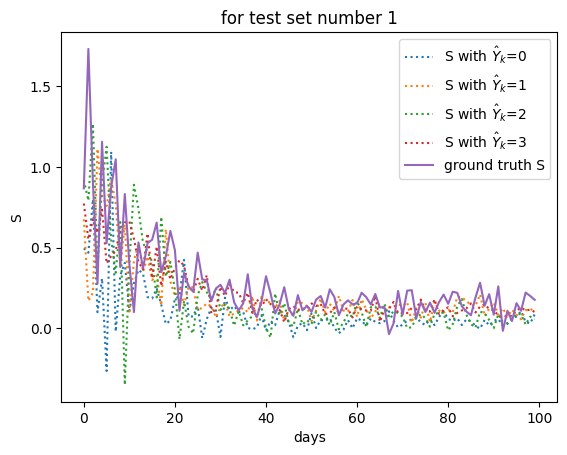

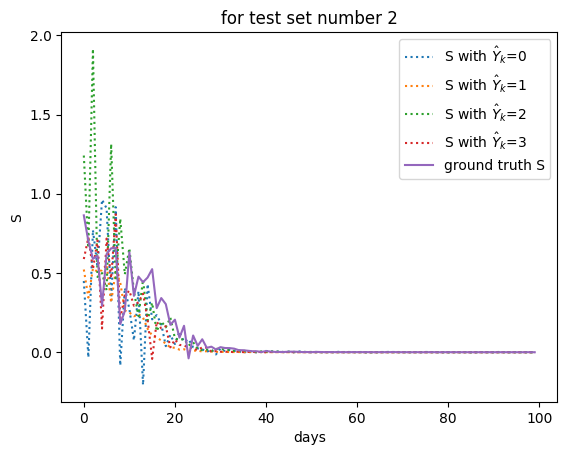

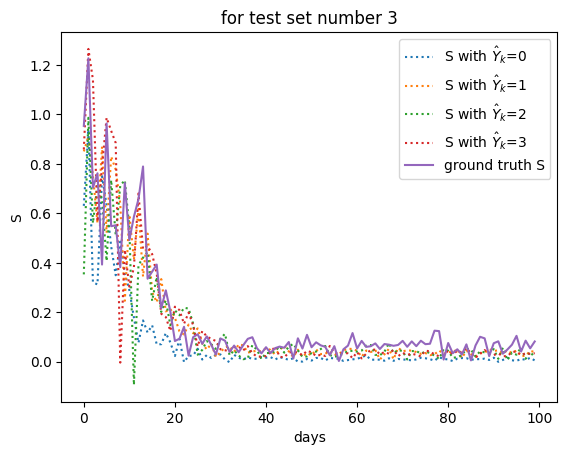

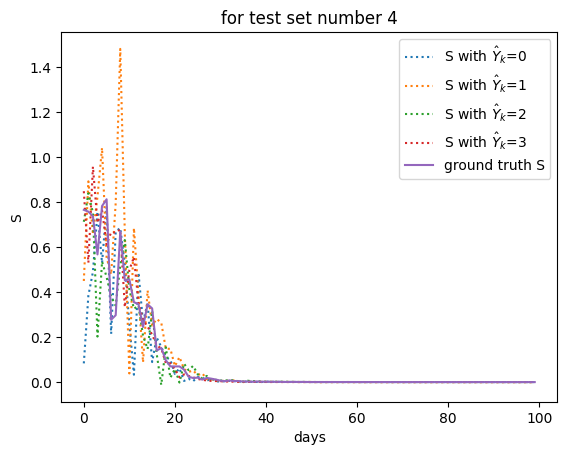

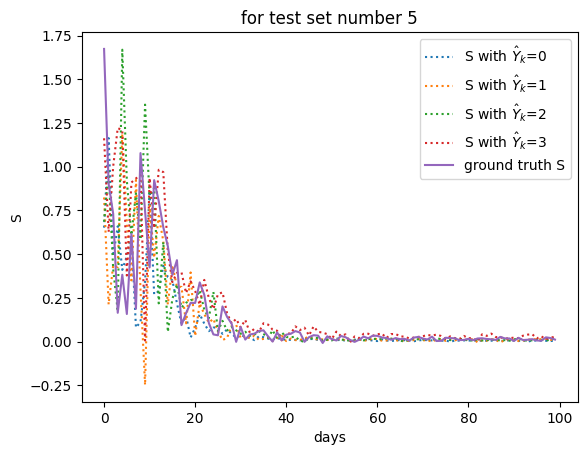

In [ ]:
test_dataset = SIRDataset_noisy(size=30, T=100)

true_count=0; false_count=0

for i in range(6):
    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    #print("input is: ", input.size())
    ground_truth = ground_truth.unsqueeze(0)
    #print("ground_truth is:", ground_truth)
    with torch.no_grad():
        samples_posterior = model.sample_posterior(input, 4)
    samples_posterior = samples_posterior.numpy()
    #print("samples_posterior are:"); print(samples_posterior)
    # print("ground truth is:")
    # print(ground_truth)
    # print(f"ground truth L is: {ground_truth[0,3]}")
    ground_truth = ground_truth.squeeze(0).numpy()
    X,_,C=simulate_sir_noisy(lam=ground_truth[0],
                              mu=ground_truth[1],
                              I_0=ground_truth[2],
                              L=int(ground_truth[3]), rho=ground_truth[4],
                           sigma_2=ground_truth[5],
                              T=T)


    num_samples_posterior= len(samples_posterior)
    T=100
    X_noise_list, C_noise_list=[],[]
    plt.figure(i)
    for j in range(num_samples_posterior):
      #print("sample_posterior[3,]:",samples_posterior[j][3])
      #print("sigma_2[j] is:",samples_posterior[j][5])
      X_noise, _ , C_noise = simulate_sir_noisy(lam=samples_posterior[j][0],
                                          mu=samples_posterior[j][1], I_0=samples_posterior[j][2],
                                          L=int(samples_posterior[j][3]), rho=samples_posterior[j][4],
                                          sigma_2=abs(samples_posterior[j][5]), T=T)
      X_noise_list.append(X_noise)
      C_noise_list.append(C_noise)


      plt.plot(range(T),C_noise[:,0], ":",label=r"S with $\hat{Y}_k$="+str(j))
    plt.plot(range(T), C[:,0],label="ground truth S")


    # lower_bound = np.percentile(C_noise, 20.5, axis=1)
    # #print("lower_bound:"); print(lower_bound)
    # upper_bound = np.percentile(C_noise, 77.5, axis=1)

    # plt.plot(range(T), lower_bound, label="lower_bound")
    # plt.plot(range(T), upper_bound, label="upper_bound")
    plt.title(f"for test set number {i}")
    plt.xlabel("days")
    plt.ylabel("S")
    plt.legend()
    plt.show()

    # is_within_interval= (lower_bound <=X[:,0] ) & (X[:,0]<= upper_bound)
    # is_delta_s_in_interval= np.all(is_within_interval)
    # print(f"Ground truth \Delta S is in predicted confidence interval: {is_delta_s_in_interval}")
    # if is_delta_s_in_interval:
    #   true_count+=1
    # else:
    #   false_count+=1

    # lower_bound = np.percentile(C_noise[:,0], 2.5, axis=0)
    # upper_bound = np.percentile(C_noise[:,0], 97.5, axis=0)

    # is_within_interval= (lower_bound <=C[:,0] ) & (C[:,0]<= upper_bound)
    # is_delta_s_in_interval= np.all(is_within_interval)
    # print(f"Ground truth \Delta S is in predicted confidence interval: {is_delta_s_in_interval}")
    # if is_delta_s_in_interval:
    #   true_count+=1
    # else:
    #   false_count+=1



#print(f"true count: {true_count} and false count is {false_count}")


lam_vals,mu_vals, I_0_vals,L_vals, rho_vals, sigma_2_vals=samples_posterior[:,0],samples_posterior[:,1],samples_posterior[:,2],samples_posterior[:,3],samples_posterior[:,4],samples_posterior[:,5]

# 3. Model misspecification detection


In [29]:
def mmd_loss(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "rbf" or "inverse-multi-quadratic"
    """
    # Compute squared Euclidean distances

    xx, yy, zz = torch.mm(x, x.T), torch.mm(y, y.T), torch.mm(x, y.T)
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.T + rx - 2. * xx
    dyy = ry.T + ry - 2. * yy
    dxy = rx.T + ry - 2. * zz

    XX, YY, XY = (torch.zeros(xx.shape),
                  torch.zeros(xx.shape),
                  torch.zeros(xx.shape))

    # Squared Exponential or Gaussian Kernel
    if kernel == "rbf":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(torch.exp(-0.5 * dxx / a) for a in bandwidth_range)
        YY = sum(torch.exp(-0.5 * dyy / a) for a in bandwidth_range)
        XY = sum(torch.exp(-0.5 * dxy / a) for a in bandwidth_range)

    # Inverse Multi-Quadratic Kernel
    if kernel == "inverse-multi-quadratic":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(1 / (dxx / a + 1) for a in bandwidth_range)
        YY = sum(1 / (dyy / a + 1) for a in bandwidth_range)
        XY = sum(1 / (dxy / a + 1) for a in bandwidth_range)

    return torch.mean(XX + YY - 2. * XY)

def nll_loss(z, ljd):
    loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd)
    return loss


In [30]:
def training_per_epoch(model, train_loader, optimizer, batchsize):
    model.train()
    loss_sum = 0
    for input, ground_truth in train_loader:
        optimizer.zero_grad()
        condition = model.summary_net(input)
        z, ljd = model.real_nvp(ground_truth, condition)
        loss = nll_loss(z,ljd) / batchsize

        standard_gaussian = torch.randn(condition.shape)
        loss += mmd_loss(condition, standard_gaussian,  kernel='rbf')
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum/len(train_loader)


def validation_per_epoch(model, validation_loader, batchsize):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for input, ground_truth in validation_loader:
            condition = model.summary_net(input)
            z, ljd = model.real_nvp(ground_truth, condition)
            loss = nll_loss(z,ljd) / batchsize
            standard_gaussian = torch.randn(condition.shape)
            #standard_gaussian = torch.normal(mean=0, std=1, size=(condition.shape))
            loss += mmd_loss(condition, standard_gaussian,  kernel='rbf')
            loss_sum += loss.item()
    return loss_sum/len(validation_loader)


def train_fusion(model, train_loader, validation_loader, batch_size=32, epochs=10, learning_rate=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = training_per_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer, batchsize=batch_size)
        validation_loss = validation_per_epoch(
            model=model, validation_loader=validation_loader, batchsize=batch_size)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss}")

In [31]:
params = {'input_size': 2*100,
          'hidden_size_sir': 50,
          'feature_size': 20,
          'n_layers_sir': 2,
          'hidden_size_nvp': 200,
          'input_size_nvp': 3,
          'blocks': 10}

training_params = {'batch_size': 32,
                   'epochs': 50,
                   'learning_rate': 0.0005,
                   'train_loader': train_loader,
                   'validation_loader': validation_loader}

train_dataset = SIRDataset(size=1000, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = SIRDataset(size=200, T=100)
test_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

model = FusionNetwork(**params)
train_fusion(model, **training_params)

Epoch [1/50], Train Loss: -3.9760, Validation Loss: -6.459132977894375
Epoch [2/50], Train Loss: -7.4749, Validation Loss: -6.742856519562857
Epoch [3/50], Train Loss: -7.5974, Validation Loss: -7.013009922845023
Epoch [4/50], Train Loss: -7.7681, Validation Loss: -6.883633119719369
Epoch [5/50], Train Loss: -7.8406, Validation Loss: -7.214416061128889
Epoch [6/50], Train Loss: -8.4382, Validation Loss: -7.330198594502041
Epoch [7/50], Train Loss: -8.4340, Validation Loss: -7.962422149521964
Epoch [8/50], Train Loss: -9.0325, Validation Loss: -7.87365448474884
Epoch [9/50], Train Loss: -8.7140, Validation Loss: -8.22453921181815
Epoch [10/50], Train Loss: -9.2405, Validation Loss: -8.59712244783129
Epoch [11/50], Train Loss: -9.4130, Validation Loss: -8.05285200050899
Epoch [12/50], Train Loss: -9.4036, Validation Loss: -7.958138806479318
Epoch [13/50], Train Loss: -9.4898, Validation Loss: -8.121776921408516
Epoch [14/50], Train Loss: -9.4481, Validation Loss: -7.5421242373330255
Epoc

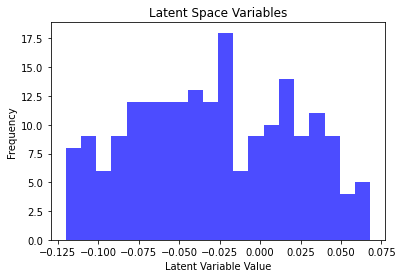

In [32]:
def plot_hx_histogram(observed_values, bins = 20):
    plt.hist(observed_values, bins=bins, alpha=0.7, color='blue')
    plt.title(f'Latent Space Variables')
    plt.xlabel('Latent Variable Value')
    plt.ylabel('Frequency')
    plt.show()

observed_values = np.zeros((model.feature_size, len(test_loader)))
for i ,(data, targets) in enumerate(test_loader):
        with torch.no_grad():
            observed_values[:, i] = model.summary_net(data)

plot_hx_histogram(observed_values[2,:])




In [33]:
import scipy.stats as stats
def check_chi_test(fusion_model, test_loader, significance_level=0.01):
    p_values = []
    n_bins = 20
    observed_values = np.zeros((fusion_model.feature_size, len(test_loader)))
    for i ,(data, targets) in enumerate(test_loader):
        with torch.no_grad():
            observed_values[:, i] = fusion_model.summary_net(data)

    for i in range(fusion_model.feature_size):
        observed_counts, bin_edges = np.histogram(observed_values[i,:], bins=n_bins, density=False)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        expected_probs = np.zeros(n_bins)
        for i in range(n_bins):
            expected_probs[i] = stats.norm.cdf(bin_edges[i], 0, 1) - stats.norm.cdf(bin_edges[i+1], 0, 1)

        # Convert probabilities to counts
        expected_counts = len(observed_values[i, :]) * expected_probs

        chi_stat, chi_p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
        p_values.append(chi_p_value)

    if any(p > significance_level for p in p_values):
        print("Null hypothesis cannot be rejected for at least one batch. h(X) follows a normal distribution.")
    else:
        print("Null hypothesis is rejected for all batches")





check_chi_test(model, test_loader, 0.01)

Null hypothesis cannot be rejected for at least one batch. h(X) follows a normal distribution.


# 4. Sensitivity analysis
